
0: 448x640 (no detections), 158.3ms
Speed: 7.1ms preprocess, 158.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

Detection Details for Winter-Fishing-On-Ice-sealed-Chagan-Lake.jpg:
--------------------------------------------------
Maximum pixel difference: 0

0: 448x640 1 orange, 158.6ms
Speed: 5.9ms preprocess, 158.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

Detection Details for test1.jpg:
Detection 1:
- Class: orange
- Confidence: 0.92
- Bounding Box: [     1771.7      909.62      3555.9      2835.9]
--------------------------------------------------
Maximum pixel difference: 0

0: 640x640 1 orange, 226.8ms
Speed: 6.8ms preprocess, 226.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

Detection Details for test2.jpg:
Detection 1:
- Class: orange
- Confidence: 0.89
- Bounding Box: [     65.624      51.612      548.96      553.67]
--------------------------------------------------
Maximum pixel difference: 0

0: 448

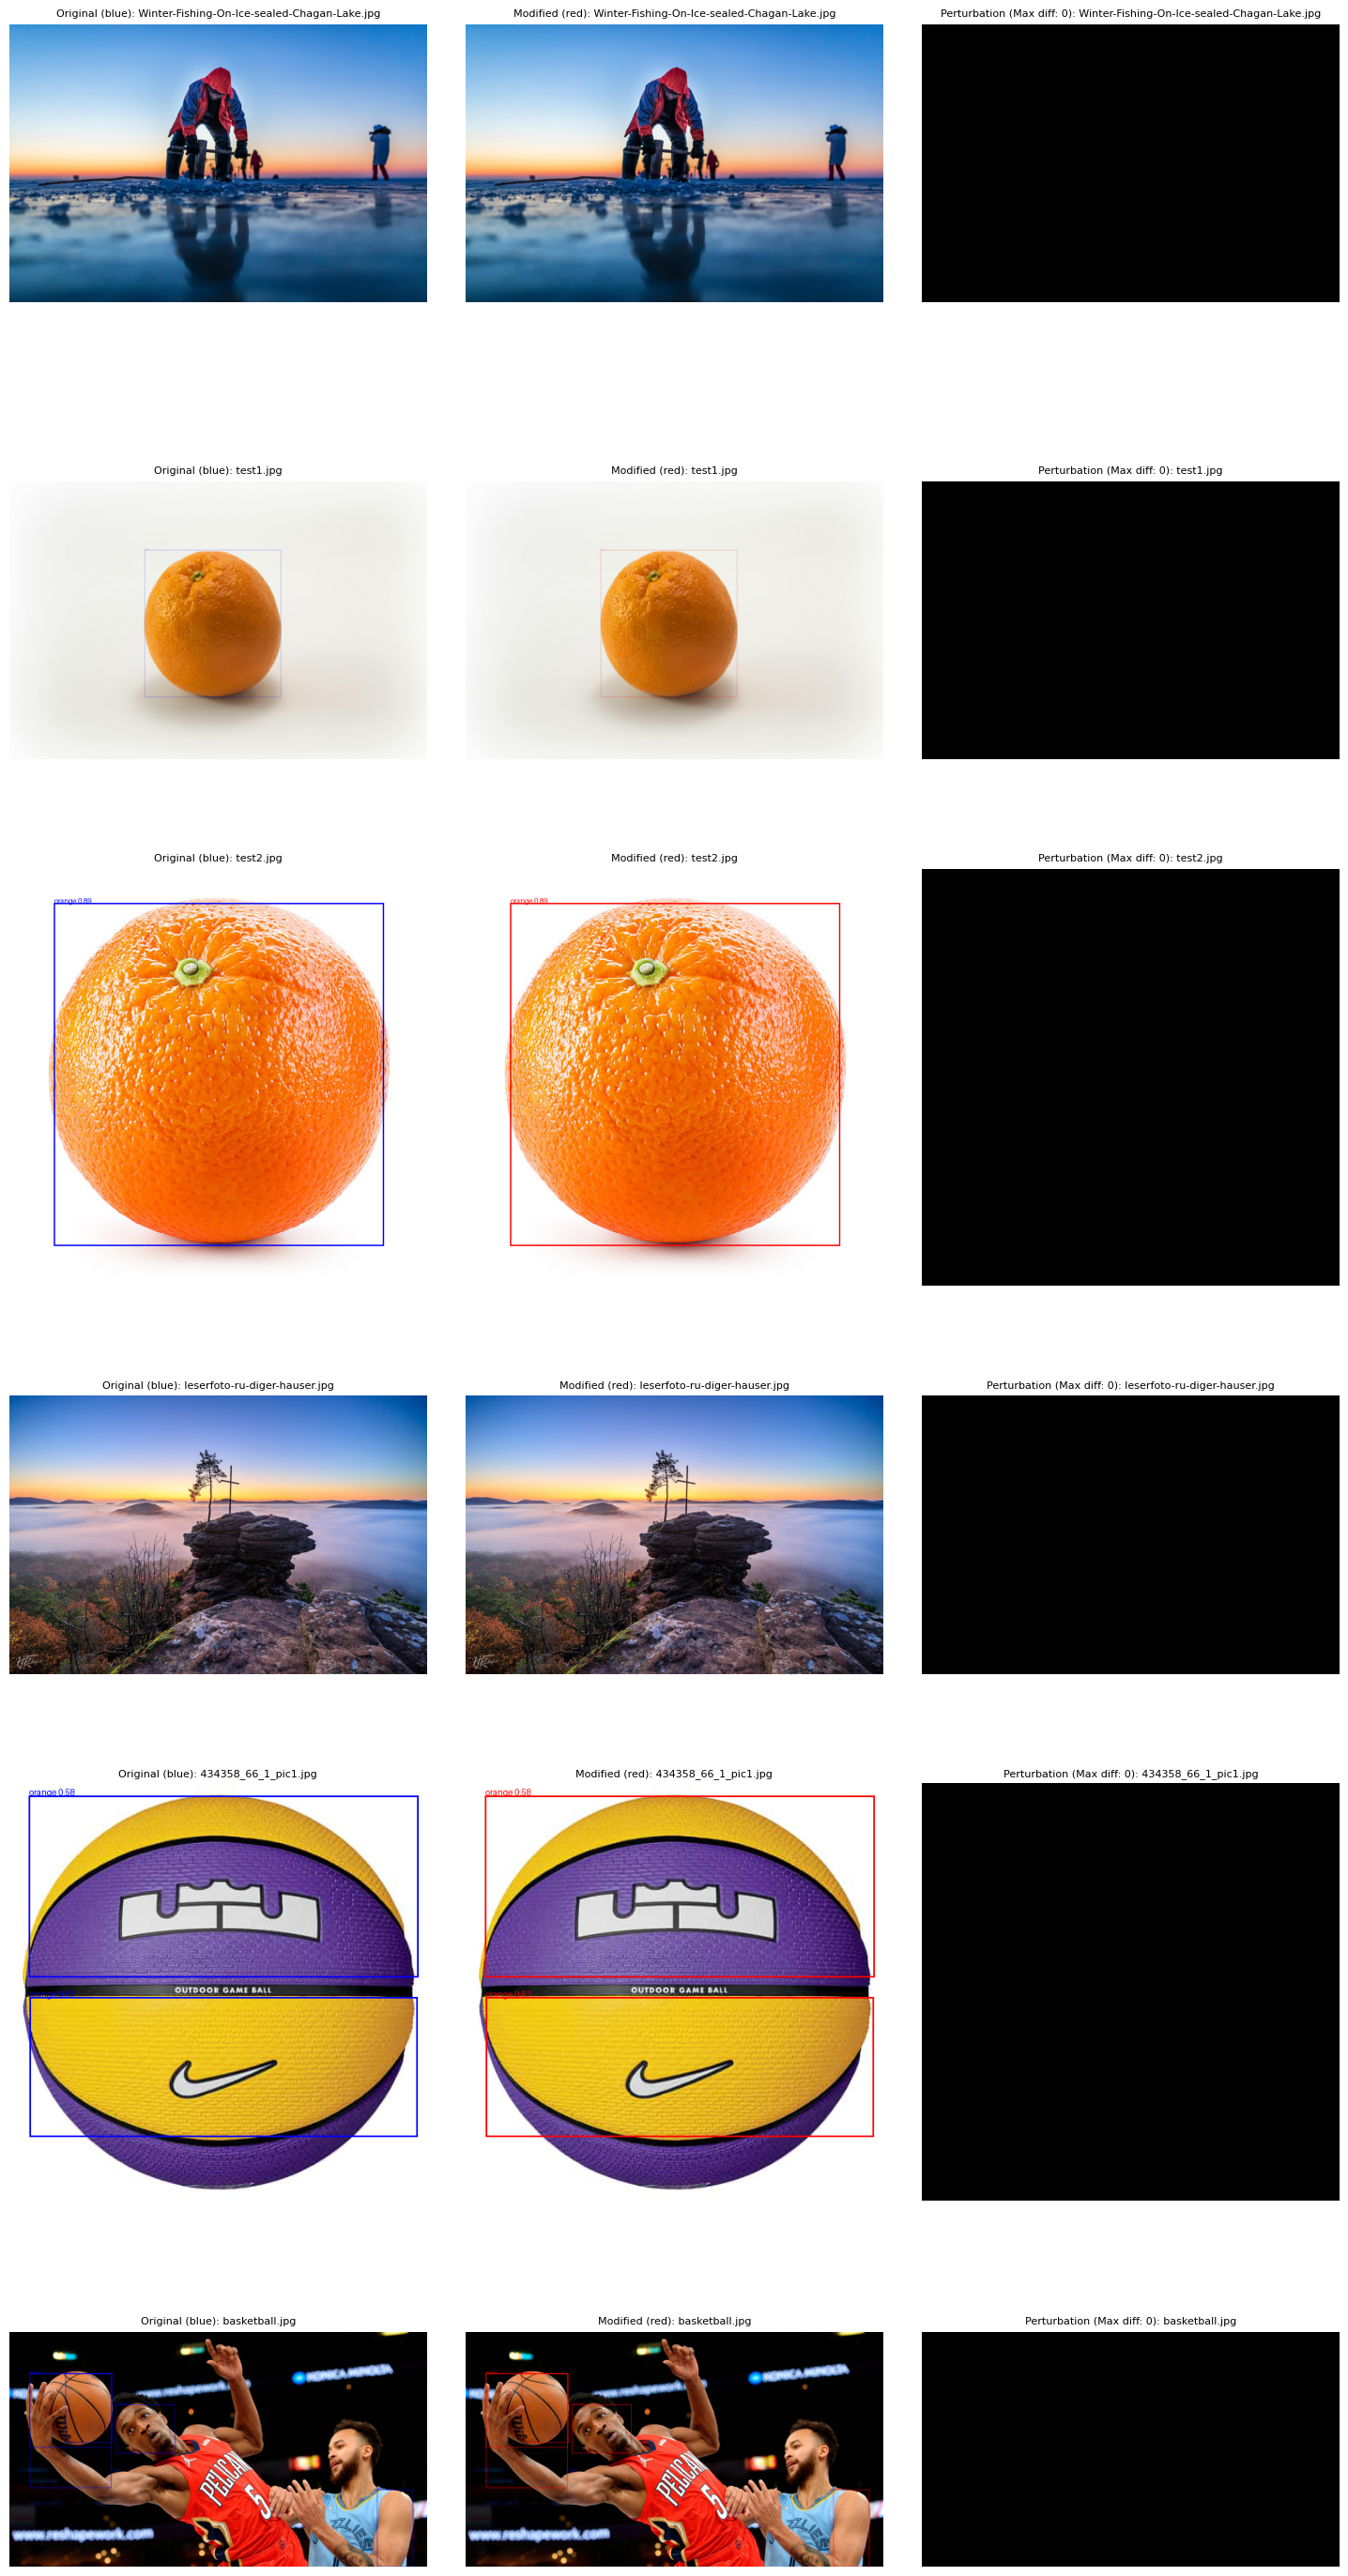

In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np


def load_model(model_path):
    """
    Load the YOLO model from the specified path.
    """
    return YOLO(model_path)


def get_image_files(folder, extensions=('.jpg', '.jpeg', '.png')):
    """
    Get a list of image files from the specified folder with the given extensions.
    """
    return [f for f in Path(folder).glob('*') if f.suffix.lower() in extensions]


def process_image(model, image_path, conf_threshold=0.25):
    """
    Process an image with the model to get predictions, and return the original,
    modified, and difference images along with the detection results.
    """
    # Load the original image
    original_image = Image.open(image_path)
    original_array = np.array(original_image)

    # Create a copy for modification (before drawing boxes)
    modified_image = original_image.copy()
    modified_array = np.array(modified_image)  # Store modified array before drawing boxes

    # Create copies for display with boxes
    display_image = original_image.copy()
    final_modified_image = original_image.copy()

    draw_display = ImageDraw.Draw(display_image)
    draw_modified = ImageDraw.Draw(final_modified_image)

    # Run predictions
    results = model.predict(original_image, conf=conf_threshold)
    result = results[0]

    # Draw boxes on display images
    for box in result.boxes:
        x1, y1, x2, y2 = box.xyxy[0].numpy()
        conf = box.conf[0]
        cls = box.cls[0]
        label = f"{result.names[int(cls)]} {conf:.2f}"

        # Draw blue boxes on display image
        draw_display.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        draw_display.text((x1, y1 - 10), label, fill="blue")

        # Draw red boxes on final modified image
        draw_modified.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw_modified.text((x1, y1 - 10), label, fill="red")

    # Calculate perturbation between original and modified (before boxes)
    perturbation = np.abs(original_array.astype(int) - modified_array.astype(int)).astype(np.uint8)

    return np.array(display_image), np.array(final_modified_image), perturbation, result


def plot_images(subplot_idx, image_path, display_image, modified_image, perturbation, num_images):
    """
    Plot images with titles.
    """
    rows = (num_images * 3 + 2) // 3
    plt.subplot(rows, 3, subplot_idx * 3 + 1)
    plt.imshow(display_image)
    plt.title(f"Original (blue): {image_path.name}", fontsize=8)
    plt.axis('off')

    plt.subplot(rows, 3, subplot_idx * 3 + 2)
    plt.imshow(modified_image)
    plt.title(f"Modified (red): {image_path.name}", fontsize=8)
    plt.axis('off')

    plt.subplot(rows, 3, subplot_idx * 3 + 3)
    plt.imshow(perturbation)
    perturbation_magnitude = np.max(perturbation)
    plt.title(f"Perturbation (Max diff: {perturbation_magnitude}): {image_path.name}", fontsize=8)
    plt.axis('off')


def print_detection_details(result, image_path):
    """
    Print detection details such as class, confidence, and bounding boxes.
    """
    print(f"\nDetection Details for {image_path.name}:")
    for i, box in enumerate(result.boxes):
        confidence = float(box.conf[0])
        class_id = int(box.cls[0])
        class_name = result.names[class_id]
        print(f"Detection {i+1}:")
        print(f"- Class: {class_name}")
        print(f"- Confidence: {confidence:.2f}")
        print(f"- Bounding Box: {box.xyxy[0].numpy()}")
    print("-" * 50)


def main(model_path, test_folder, conf_threshold=0.25):
    """
    Main function to process and visualize images.
    """
    # Load YOLO model
    model = load_model(model_path)

    # Get list of image files
    image_files = get_image_files(test_folder)

    # Setup plot figure
    num_images = len(image_files)
    plt.figure(figsize=(15, 5 * ((num_images * 3 + 2) // 3)))

    # Process each image
    for idx, image_path in enumerate(image_files):
        display_image, modified_image, perturbation, result = process_image(model, image_path, conf_threshold)
        plot_images(idx, image_path, display_image, modified_image, perturbation, num_images)
        print_detection_details(result, image_path)

        # Print maximum perturbation value
        perturbation_magnitude = np.max(perturbation)
        print(f"Maximum pixel difference: {perturbation_magnitude}")

    # Show the final plot
    plt.tight_layout(pad=3.0)
    plt.show()


# Parameters
MODEL_PATH = "/Users/lastjan/Development/KI die 2/JupyterProject/.../best.pt"
TEST_FOLDER = "/Users/lastjan/Development/KI die 2/JupyterProject/dataset/images/test"
CONFIDENCE_THRESHOLD = 0.25

if __name__ == "__main__":
    main(MODEL_PATH, TEST_FOLDER, CONFIDENCE_THRESHOLD)